In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from sklearn.model_selection import train_test_split


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Embedding, Flatten, Input, Multiply, Reshape, Dropout, LeakyReLU, Conv2D, Conv2DTranspose, ELU,
                                    GaussianNoise, ActivityRegularization, Add, PReLU, ReLU)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam, Adamax, Ftrl
from tensorflow.keras.losses import CosineSimilarity, Huber, LogCosh
from tensorflow.keras.initializers import he_normal, he_uniform, glorot_uniform
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [3]:
df = pd.read_csv('data/f_train.csv')
X = df.drop(['cent_price_cor', 'cent_trans_cor'],axis=1).values
y = df[['cent_price_cor', 'cent_trans_cor']].values

In [4]:
def add_dense(x, n):
    x = Dense(n, 
              kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), 
              use_bias=False,
              kernel_initializer=he_normal())(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    return x

def output_layer(x, name):
    return Dense(1, 
                 activation="tanh", 
                 name=name,
                 use_bias=False,
                 kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), 
                 kernel_initializer=glorot_uniform())(x)


In [5]:
in_  = Input(shape=(X.shape[1],))
x    = add_dense(in_, 10)
out1 = output_layer(x, "price_out")
out2 = output_layer(x, "trans_out")

model = Model(in_, [out1, out2])

In [6]:
losses = {"price_out": "mae", "trans_out": "mae"}
weights = {"price_out": 1, "trans_out": 1}
model.compile(loss=losses, loss_weights=weights, optimizer=Adam(lr=0.001, epsilon=1e-8), metrics=['mae'])

In [7]:
earlystop = EarlyStopping(monitor='val_trans_out_mae', min_delta=0.0001, patience=100, verbose=1, restore_best_weights=True)

In [8]:
f_y = {"price_out": y[:,0], "trans_out": y[:,1]}
model.fit(X,f_y, epochs=400, callbacks=[], validation_split=0.1, shuffle=True, batch_size=2000, verbose=0)

In [9]:
df_test = pd.read_csv('data/f_test.csv')
test = df_test.drop(['id'],axis=1)
id_test = df_test['id']

y_pred = model.predict(test)
print(y_pred[0].reshape(-1).shape)
bruh = {"price": y_pred[0].reshape(-1), "trans": y_pred[1].reshape(-1)}
result = pd.DataFrame(bruh)
result.describe()

(8059,)


,price,trans
count,8059.000000,8059.000000
mean,-0.155437,0.387473
std,0.032055,0.016661
min,-0.199464,0.334421
25%,-0.180038,0.376367
50%,-0.162709,0.384600
75%,-0.138311,0.395627
max,-0.005305,0.474573


<AxesSubplot:xlabel='cent_price_cor', ylabel='Probability'>

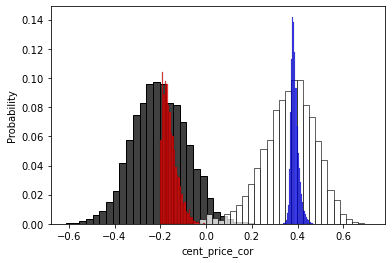

In [10]:
sns.histplot(data=df, x='cent_price_cor', stat="probability", bins=30, color='black')
sns.histplot(data=df, x='cent_trans_cor', stat="probability", bins=30, color='w')

sns.histplot(data=result, x='price', stat="probability",bins=30, color='r')
sns.histplot(data=result, x='trans', stat="probability", bins=30, color='b')